In [1]:
import numpy as np
from scipy.fft import fft, ifft, fftshift
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt
import pickle
from copy import copy
%matplotlib inline

In [2]:
with open('data_set_1.pkl', 'rb') as f:
    data_set_1 = pickle.load(f)

xvals1 = data_set_1[:, 0]
yvals1 = data_set_1[:, 1]

In [3]:
def xp_mat_maker(xvals, p):
    xp = np.ones((xvals.size, p+1))
    for jj in range(p):
        xp[:, jj+1] = xvals * xp[:, jj]
    return xp

In [4]:
def least_squares_solve(mat, yvals):
    u, s, vt = np.linalg.svd(mat, full_matrices=False)
    alpha = (vt.T @ np.diag(1./s) @ u.T) @ yvals.reshape(-1, 1)
    error = np.linalg.norm(mat @ alpha - yvals.reshape(-1, 1))**2./(2.*yvals.size)
    return alpha, error 

In [42]:
def cross_fold(alpha, xvals, yvals, pval, kfolds):

    kf = KFold(n_splits=kfolds)
    w_avg = np.zeros(pval+1)
    errors = np.zeros(kfolds)
    cnt = 0

    for train, test in kf.split(xvals):
        xtrain, ytrain = xvals[train], yvals[train]
        xtest, ytest = xvals[test], yvals[test]
        xp_train = xp_mat_maker(xtrain, pval)        
        res = Lasso(alpha, max_iter=16000, tol=1e-4).fit(xp_train, ytrain) # alpha > 0
        w_lasso = res.coef_
        w_avg += w_lasso
        
        xp_test = xp_mat_maker(xtest,pval)
        errors[cnt] = np.linalg.norm(xp_test @ w_lasso.reshape(-1,1) - ytest)/np.sqrt(2.*ytest.size)
        cnt += 1
        
    error = np.mean(errors)
    var = np.std(errors)
    return w_avg/kfolds, error, var

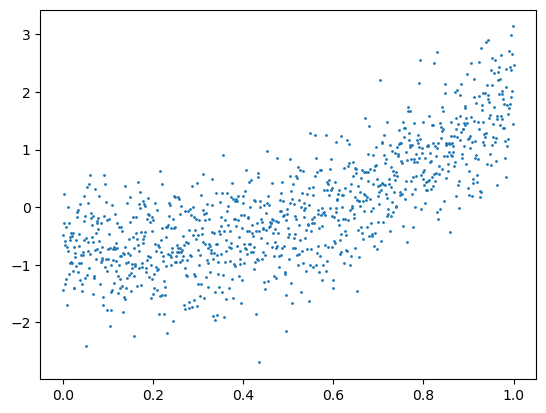

In [43]:
# rescale data
xmax = np.max(xvals1)
ymean = np.mean(yvals1)
ystd = np.std(yvals1)

xvalsrsc = xvals1/xmax
yvalsrsc = (yvals1-ymean)/ystd

plt.scatter(xvalsrsc, yvalsrsc, s=1.)

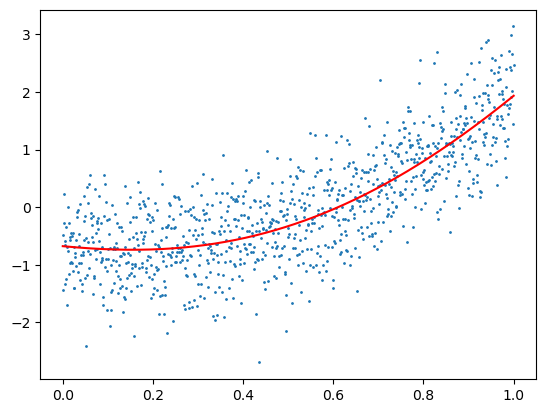

In [44]:
pval = 4
xp = xp_mat_maker(xvalsrsc, pval)
alpha, error = least_squares_solve(xp, yvalsrsc)
yfit = xp @ alpha.reshape(-1,1)
plt.plot(xvalsrsc, yfit, color='r')
plt.scatter(xvalsrsc, yvalsrsc, s=1.)

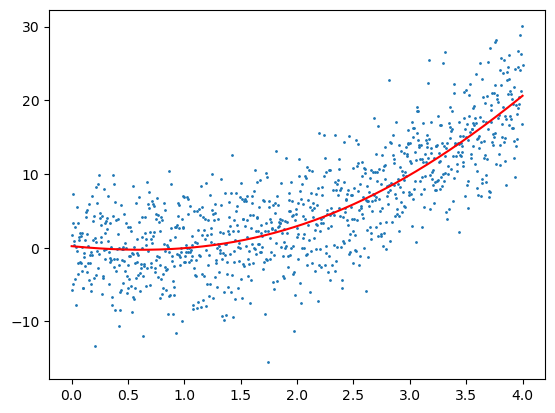

In [45]:
yfit = ystd*yfit + ymean
plt.plot(xvals1,yfit,color='r')
plt.scatter(xvals1, yvals1, s=1.)

In [46]:
numlams = 30
lampows = np.linspace(-6., 0, numlams) # choices, choices
errors = np.zeros(lampows.size)
stds = np.zeros(lampows.size)
pval = 10
kfolds = 50

avalsvslam = np.zeros((pval+1, numlams))
for jj, lampow in enumerate(lampows):
    lam = 10**(lampow)    
    w_avg, mean, std = cross_fold(lam, xvalsrsc, yvalsrsc, pval, kfolds)
    avalsvslam[:, jj] = w_avg
    errors[jj] = mean
    stds[jj] = std

/home/ccurtis/.conda/envs/math_596_fall_2024/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.439e+02, tolerance: 9.851e-02
  model = cd_fast.enet_coordinate_descent(
/home/ccurtis/.conda/envs/math_596_fall_2024/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.458e+02, tolerance: 9.867e-02
  model = cd_fast.enet_coordinate_descent(
/home/ccurtis/.conda/envs/math_596_fall_2024/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

Text(0, 0.5, 'Mean Error')

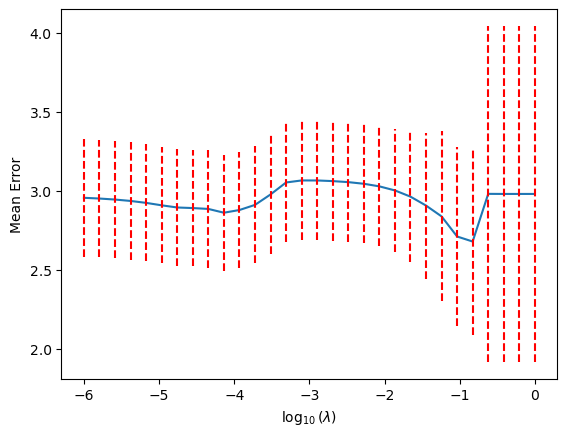

In [49]:
plt.plot(lampows, errors) # how would you plot the standard devations as error bars around the mean of the error?
for jj in range(stds.size):
    ejp = errors[jj] + stds[jj]
    ejm = errors[jj] - stds[jj]
    plt.plot([lampows[jj], lampows[jj]], [ejm, ejp], ls='--', c='r')
plt.xlabel(r"$\log_{10}(\lambda)$");
plt.ylabel(r"Mean Error")

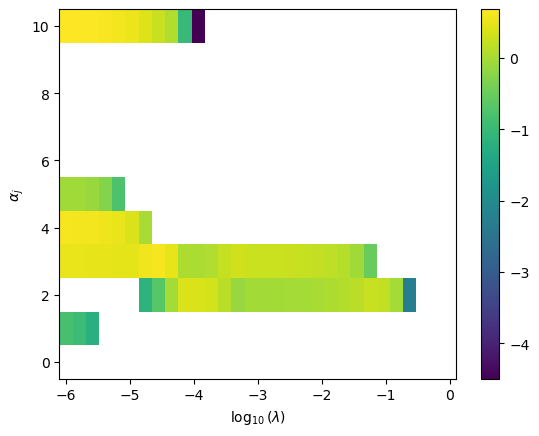

In [50]:
cfig = plt.pcolormesh(lampows, np.arange(pval+1), np.ma.log10(avalsvslam))
plt.xlabel(r"$\log_{10}(\lambda)$")
plt.ylabel(r"$\alpha_{j}$")
plt.colorbar(cfig);